In [1]:
%cd ../data

/home/explorer/BMS270/data


In [2]:
import numpy as np

In [3]:
def clip(s):
    return max(0,int(float(s)+.5))

In [4]:
from csv import reader, excel_tab
orfs = []
names = []
data = []
fin = reader(open("GSE88801_kallisto_est_counts_thresh10.cdt"),dialect=excel_tab)
header = next(fin)[4:]
eweights = next(fin)[4:]
for row in fin:
    orfs.append(row[1])
    names.append(row[2])
    data.append([clip(i) for i in row[4:]])

In [5]:
C = np.array(data)
C.shape

(9939, 36)

In [6]:
from csv import reader

In [7]:
fp = reader(open("sample_table_v2.csv"))
sample_header = next(fp)
samples = []
name2sample = {}
for i in fp:
    samples.append(i)
    name2sample[i[0]] = i

In [8]:
sample_header

['name', 'infection', 'strain', 'time', 'replicate']

In [9]:
out = open("sample_table_v2.tdt","w")
out.write("\t".join(sample_header+["state"])+"\n")
for i in header:
    s = name2sample[i]
    out.write("\t".join(s + ["%s.%s.%s" % (s[2],s[1],s[3])])+"\n")
out.close()

In [10]:
out = open("GSE88801_kallisto_est_counts_thresh10.txt","w")
out.write("\t".join(["gene"]+header)+"\n")
for (name,row) in zip(names,C):
    out.write("\t".join([name]+[str(i) for i in row])+"\n")
out.close()

In [12]:
%load_ext rpy2.ipython

In [13]:
%%R
library(limma)
library(edgeR)

In [14]:
%%R
samples <- read.delim("sample_table_v2.tdt")
print(summary(samples))

         name         infection   strain        time      replicate
 GSM2348248: 1   Dead      :12   BMDM:18   Min.   : 4   Min.   :1  
 GSM2348249: 1   Live      :12   J774:18   1st Qu.: 4   1st Qu.:1  
 GSM2348250: 1   uninfected:12             Median :14   Median :2  
 GSM2348251: 1                             Mean   :14   Mean   :2  
 GSM2348252: 1                             3rd Qu.:24   3rd Qu.:3  
 GSM2348253: 1                             Max.   :24   Max.   :3  
 (Other)   :30                                                     
                state   
 BMDM.Dead.24      : 3  
 BMDM.Dead.4       : 3  
 BMDM.Live.24      : 3  
 BMDM.Live.4       : 3  
 BMDM.uninfected.24: 3  
 BMDM.uninfected.4 : 3  
 (Other)           :18  


In [15]:
%%R
state <- samples$state

d <- model.matrix(~0+state)
colnames(d) <- gsub("state","",colnames(d))
print(colnames(d))

 [1] "BMDM.Dead.24"       "BMDM.Dead.4"        "BMDM.Live.24"      
 [4] "BMDM.Live.4"        "BMDM.uninfected.24" "BMDM.uninfected.4" 
 [7] "J774.Dead.24"       "J774.Dead.4"        "J774.Live.24"      
[10] "J774.Live.4"        "J774.uninfected.24" "J774.uninfected.4" 


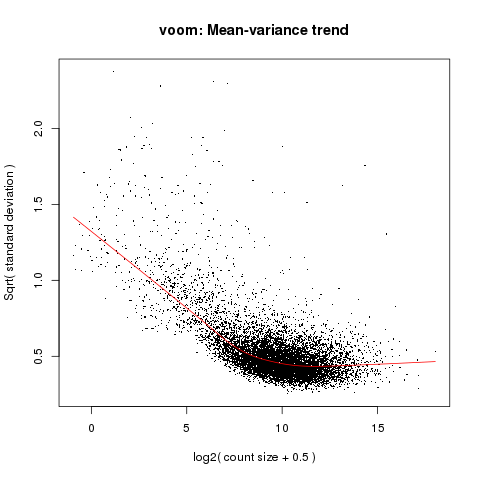

In [16]:
%%R
C <- read.delim("GSE88801_kallisto_est_counts_thresh10.txt",row.names=1)
dge <- DGEList(counts=C)
dge <- calcNormFactors(dge)
v <- voom(dge, d, plot = TRUE)

In [17]:
%%R
fit <- lmFit(v, d)

contrast.matrix <- makeContrasts(# S1 contrast
                                 BMDM.uninfected.24-BMDM.uninfected.4,
                                 # S2 contrasts
                                 BMDM.Live.4-BMDM.uninfected.4,BMDM.Dead.4-BMDM.uninfected.4,
                                 BMDM.Live.24-BMDM.uninfected.24,BMDM.Dead.24-BMDM.uninfected.24,
                                 J774.Live.4-J774.uninfected.4,J774.Dead.4-J774.uninfected.4,
                                 J774.Live.24-J774.uninfected.24,J774.Dead.24-J774.uninfected.24,
                                 levels=d)

fit2 <- contrasts.fit(fit, contrast.matrix)
fit2 <- eBayes(fit2)
print(summary(decideTests(fit2)))

   BMDM.uninfected.24 - BMDM.uninfected.4 BMDM.Live.4 - BMDM.uninfected.4
-1                                   2069                            2288
0                                    5706                            5895
1                                    2164                            1756
   BMDM.Dead.4 - BMDM.uninfected.4 BMDM.Live.24 - BMDM.uninfected.24
-1                            1798                              2050
0                             6672                              5845
1                             1469                              2044
   BMDM.Dead.24 - BMDM.uninfected.24 J774.Live.4 - J774.uninfected.4
-1                              1267                             232
0                               7377                            9293
1                               1295                             414
   J774.Dead.4 - J774.uninfected.4 J774.Live.24 - J774.uninfected.24
-1                             162                              2059
0             

In [18]:
%%R
print(summary(decideTests(fit2,lfc=1)))

   BMDM.uninfected.24 - BMDM.uninfected.4 BMDM.Live.4 - BMDM.uninfected.4
-1                                    680                             673
0                                    8581                            8478
1                                     678                             788
   BMDM.Dead.4 - BMDM.uninfected.4 BMDM.Live.24 - BMDM.uninfected.24
-1                             478                               725
0                             8794                              8512
1                              667                               702
   BMDM.Dead.24 - BMDM.uninfected.24 J774.Live.4 - J774.uninfected.4
-1                               383                              37
0                               9119                            9755
1                                437                             147
   J774.Dead.4 - J774.uninfected.4 J774.Live.24 - J774.uninfected.24
-1                              21                               560
0             

In [19]:
%%R
print(topTable(fit2))

                   BMDM.uninfected.24...BMDM.uninfected.4
ENSMUSG00000000957                              0.6866017
ENSMUSG00000023341                              0.9722481
ENSMUSG00000050370                             -4.7094262
ENSMUSG00000030142                             -0.4031129
ENSMUSG00000031613                              2.7702055
ENSMUSG00000082292                              1.3588915
ENSMUSG00000074896                              1.7229340
ENSMUSG00000028270                              2.3299295
ENSMUSG00000037405                              0.6149907
ENSMUSG00000029561                              0.7866550
                   BMDM.Live.4...BMDM.uninfected.4
ENSMUSG00000000957                        4.750471
ENSMUSG00000023341                        6.196596
ENSMUSG00000050370                        2.536793
ENSMUSG00000030142                        5.067034
ENSMUSG00000031613                       -1.115454
ENSMUSG00000082292                        5.663051
ENSMU

In [23]:
%%R
print(colnames(fit2$coefficients))

[1] "BMDM.uninfected.24 - BMDM.uninfected.4"
[2] "BMDM.Live.4 - BMDM.uninfected.4"       
[3] "BMDM.Dead.4 - BMDM.uninfected.4"       
[4] "BMDM.Live.24 - BMDM.uninfected.24"     
[5] "BMDM.Dead.24 - BMDM.uninfected.24"     
[6] "J774.Live.4 - J774.uninfected.4"       
[7] "J774.Dead.4 - J774.uninfected.4"       
[8] "J774.Live.24 - J774.uninfected.24"     
[9] "J774.Dead.24 - J774.uninfected.24"     


In [24]:
%%R
print(topTable(fit2, coef="BMDM.uninfected.24 - BMDM.uninfected.4", lfc=1, p.value = .05))

                       logFC     AveExpr         t      P.Value    adj.P.Val
ENSMUSG00000031613  2.770205  0.01606512  25.32290 3.756218e-21 3.733305e-17
ENSMUSG00000022351 -2.698628  6.47320365 -20.97155 6.354449e-19 3.157843e-15
ENSMUSG00000070348 -4.363873  8.41934975 -20.14689 1.868026e-18 6.188771e-15
ENSMUSG00000024030  2.740424  6.82440038  19.27584 6.089099e-18 1.354941e-14
ENSMUSG00000053040  2.759973  3.40438541  19.19441 6.816285e-18 1.354941e-14
ENSMUSG00000036833  1.691108  5.42121904  18.69190 1.380075e-17 1.959509e-14
ENSMUSG00000013089 -4.054002  5.10816666 -18.81725 1.155646e-17 1.914328e-14
ENSMUSG00000034926 -2.653638 -0.35467127 -18.51025 1.788036e-17 1.974587e-14
ENSMUSG00000029650  2.840585  2.30118767  18.35677 2.229184e-17 2.215586e-14
ENSMUSG00000032915  3.768694 -0.63361827  18.55579 1.675283e-17 1.974587e-14
                          B
ENSMUSG00000031613 38.20381
ENSMUSG00000022351 33.11143
ENSMUSG00000070348 32.13549
ENSMUSG00000024030 30.99876
ENSMUSG000000

In [25]:
%%R
for(tc in colnames(fit2$coefficients)){
  print(tc)
  # Extract all genes significantly differential on this contrast for a 2x fold change cutoff and 5% FDR
  # Use write.csv rather than write.table for clean compatibility with python's csv.reader
  write.csv(topTable(fit2, coef=tc, n = 40000, lfc=1, p.value = .05),
            paste("limma1.",gsub(" ","",tc),".t0.csv",sep=""))
  # Extract the adjusted p-values for this contrast for all genes, independent of significance
  write.csv(topTable(fit2, coef=tc, n = 40000),
            paste("limma1.",gsub(" ","",tc),".t1.csv",sep=""))
}

[1] "BMDM.uninfected.24 - BMDM.uninfected.4"
[1] "BMDM.Live.4 - BMDM.uninfected.4"
[1] "BMDM.Dead.4 - BMDM.uninfected.4"
[1] "BMDM.Live.24 - BMDM.uninfected.24"
[1] "BMDM.Dead.24 - BMDM.uninfected.24"
[1] "J774.Live.4 - J774.uninfected.4"
[1] "J774.Dead.4 - J774.uninfected.4"
[1] "J774.Live.24 - J774.uninfected.24"
[1] "J774.Dead.24 - J774.uninfected.24"
